In [137]:
from model import DAGLearner
import pandas as pd
import os
import tqdm
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.special import expit, logit
from sklearn.preprocessing import PolynomialFeatures
import sklearn
import statsmodels.api as sm
data_fn = 'data'
results_fn = 'results'
plots_fn = 'simulation_tests'

In [176]:
def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))


def gen_simple_linear_confounder(N):
    uz = np.random.randn(N, 1)
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)

    Z = uz
    xp = sigm(0.7 * Z + ux)
    X = np.random.binomial(1, xp, (N, 1))

    Y1 = -0.7 + 0.8 * Z + uy  # total effect = -0.7
    Y0 =  0.8 * Z + uy  # total effect = -0.7
    Y = Y1 * X + Y0 * (1 - X)

    all_data = pd.DataFrame(np.concatenate([Z, X, Y], 1))
    all_data.columns = ['Z', 'X', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z', 'X'), ('X', 'Y'), ('Z', 'Y')])
    return all_data, DAGnx, var_types, Y1, Y0

def gen_linear_many_confounders(N):
    
    uz1 = np.random.randn(N, 1)
    uz2 = np.random.randn(N, 1)
    uz3 = np.random.randn(N, 1)
    uz4 = np.random.randn(N, 1)
    uz5 = np.random.randn(N, 1)
    uz6 = np.random.randn(N, 1)
    uz7 = np.random.randn(N, 1)
    uz8 = np.random.randn(N, 1)
    uz9 = np.random.randn(N, 1)
    uz10 = np.random.randn(N, 1)
    uz11 = np.random.randn(N, 1)
    uz12 = np.random.randn(N, 1)   
    
    # correlated confounders
    Z1 = uz1
    Z2 = uz2
    Z3 = uz3
    Z4 = 0.1 * Z3 + uz4
    Z5 = -0.2 * Z2 + uz5
    Z6 = -.3 * Z5 + uz6
    Z7 = uz7
    Z8 = 0.5 * Z7 + uz8
    Z9 = uz9
    Z10 = 0.4 * Z9 + uz10
    Z11 = 0.5 * Z10 + uz11
    Z12 = uz12
    
    
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)
    xp = sigm(0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + ux)
    X = np.random.binomial(1, xp, (N, 1))

    Y1 = -0.7 + 0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + uy
    Y0 =  0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + uy
    
    Y = Y1 * X + Y0 * (1 - X)
    
    all_data = pd.DataFrame(np.concatenate([Z1, Z2, Z3, Z4, Z5, Z6, Z7, Z8, Z9, Z10, Z11, Z12, X, Y], 1))
    all_data.columns = ['Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10','Z11','Z12', 'X', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z1': 'cont','Z2': 'cont', 'Z3': 'cont', 'Z4': 'cont', 'Z5': 'cont', 
                 'Z6': 'cont', 'Z7': 'cont', 'Z8': 'cont', 'Z9': 'cont', 'Z10': 'cont', 
                 'Z11': 'cont', 'Z12': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z3', 'Z4'),('Z2', 'Z5'),('Z5', 'Z6'),('Z7', 'Z8'),('Z9', 'Z10'),
                          ('Z10', 'Z11'),('Z1', 'X'), ('Z2', 'X'),('Z3', 'X'),('Z4', 'X'),('Z5', 'X'),
                          ('Z6', 'X'),('Z7', 'X'),('Z8', 'X'),('Z9', 'X'),('Z10', 'X'),
                          ('Z11', 'X'),('Z12', 'X'),('Z1', 'Y'), ('Z2', 'Y'),('Z3', 'Y'),
                          ('Z4', 'Y'),('Z5', 'Y'),('Z6', 'Y'),('Z7', 'Y'),('Z8', 'Y'),
                          ('Z9', 'Y'),('Z10', 'Y'),('Z11', 'Y'),('Z12', 'Y'),('X', 'Y'),])
    return all_data, DAGnx, var_types, Y1, Y0


def gen_linear_many_ortho_confounders(N):
    
    uz1 = np.random.randn(N, 1)
    uz2 = np.random.randn(N, 1)
    uz3 = np.random.randn(N, 1)
    uz4 = np.random.randn(N, 1)
    uz5 = np.random.randn(N, 1)
    uz6 = np.random.randn(N, 1)
    uz7 = np.random.randn(N, 1)
    uz8 = np.random.randn(N, 1)
    uz9 = np.random.randn(N, 1)
    uz10 = np.random.randn(N, 1)
    uz11 = np.random.randn(N, 1)
    uz12 = np.random.randn(N, 1)   
    
    # correlated confounders
    Z1 = uz1
    Z2 = uz2
    Z3 = uz3
    Z4 = uz4
    Z5 = uz5
    Z6 = uz6
    Z7 = uz7
    Z8 = uz8
    Z9 = uz9
    Z10 = uz10
    Z11 = uz11
    Z12 = uz12
    
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)
    
    xp = sigm(0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + ux)
    X = np.random.binomial(1, xp, (N, 1))
    
    Y1 = -0.7 + 0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + uy
    Y0 =  0.3 * Z1 + 0.4 *Z2 + 0.5 * Z3 + 0.6 * Z4 - 0.1*Z5 - 0.2 * Z6 - 0.3*Z7 - 0.4 *Z8 +\
            0.5 * Z9 + 0.6 * Z10 - 0.6 *Z11 + 0.7 * Z12 + uy
    
    Y = Y1 * X + Y0 * (1 - X)
    
    all_data = pd.DataFrame(np.concatenate([Z1, Z2, Z3, Z4, Z5, Z6, Z7, Z8, Z9, Z10, Z11, Z12, X, Y], 1))
    all_data.columns = ['Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10','Z11','Z12', 'X', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z1': 'cont','Z2': 'cont', 'Z3': 'cont', 'Z4': 'cont', 'Z5': 'cont', 
                 'Z6': 'cont', 'Z7': 'cont', 'Z8': 'cont', 'Z9': 'cont', 'Z10': 'cont', 
                 'Z11': 'cont', 'Z12': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z1', 'X'), ('Z2', 'X'),('Z3', 'X'),('Z4', 'X'),('Z5', 'X'),
                          ('Z6', 'X'),('Z7', 'X'),('Z8', 'X'),('Z9', 'X'),('Z10', 'X'),
                          ('Z11', 'X'),('Z12', 'X'),('Z1', 'Y'), ('Z2', 'Y'),('Z3', 'Y'),
                          ('Z4', 'Y'),('Z5', 'Y'),('Z6', 'Y'),('Z7', 'Y'),('Z8', 'Y'),
                          ('Z9', 'Y'),('Z10', 'Y'),('Z11', 'Y'),('Z12', 'Y'),('X', 'Y'),])
    return all_data, DAGnx, var_types, Y1, Y0

def gen_simple_nonlinear_confounder(N):
    
    uz1 = np.random.randn(N, 1)
    uz2 = np.random.randn(N, 1)
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)

    Z1 = uz1
    Z2 = uz2
    
    xp = sigm(0.7 * Z1 + 0.4 * Z1*Z2 + 0.4 *Z2 + ux)
    X = np.random.binomial(1, xp, (N, 1))
    
    Y0 = 0.3 + 0.8 * Z1 + 0.3 * Z1*Z2 + 0.5*Z2**2 + uy
    Y1 = 0.3 + 0.7  + 0.5 +  0.3 + 0.8 * Z1 + 0.3 * Z1*Z2 + 0.5*Z2**2 + uy
    
    Y = Y1 * X + Y0 * (1 - X)
    
    all_data = pd.DataFrame(np.concatenate([Z1, Z2, X, Y], 1))
    all_data.columns = ['Z1', 'Z2', 'X', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'Z1': 'cont','Z2': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('Z1', 'X'), ('Z2', 'X'),('X', 'Y'), ('Z1', 'Y'), ('Z2', 'Y')])
    return all_data, DAGnx, var_types, Y1, Y0

def gen_simple_linear_mediation(N):
    um = np.random.randn(N, 1)
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)
    
    X = ux
    xp = sigm(ux)
    X = np.random.binomial(1, xp, (N, 1))
    
    m1 = 0.8 + um  
    m0 = um
    
    M = m1 * X + m0 * (1 - X)

    Y1 = 0.5 + 0.8 * m1 + uy   # direct effect = 0.5, indirect = 0.8 * 0.8, total = 1.14
    Y0 = 0.8 * m0 + uy  
    
    Y = Y1 * X + Y0 * (1 - X)
    
    all_data = pd.DataFrame(np.concatenate([X, M, Y], 1))
    all_data.columns = ['X', 'M', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'M': 'cont', 'X': 'bin', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('X', 'M'), ('M', 'Y'), ('X', 'Y')])
    return all_data, DAGnx, var_types, Y1, Y0


def gen_simple_moderation(N):
    uc = np.random.randn(N, 1)
    ux = np.random.randn(N, 1)
    uy = np.random.randn(N, 1)
    ur = np.random.randn(N, 1)
    
    rp = sigm(ur)
    R = np.random.binomial(1, rp, (N, 1))

    X = 0.6* C + ux
    
    # outcomes:
    Y = 0.8 * X + 0.7 * C + 0.4*R*X + 0.2 * R1 + uy
    
    all_data = pd.DataFrame(np.concatenate([X, M, Y, R1], 1))
    all_data.columns = ['X', 'C', 'Y', 'R']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'C': 'cont','R': 'bin', 'X': 'cont', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('X', 'Y'), ('C', 'X'), ('C', 'Y'), ('R', 'Y')])
    return all_data, DAGnx, var_types


def gen_simple_poly(N, p, degree=3):
    uy = np.random.randn(N,1)
    X2 = np.random.randn(N, 1)
    # Generate 1000 random X1, X2 values
    X1 = 0.5 * X2 + np.random.uniform(-10, 10, (N,1))
    
    poly = PolynomialFeatures(degree)
    X1_t = poly.fit_transform(X1)
    
    min_p = p - 0.666*p
    poly_coeffs = np.arange(min_p, p, (p-min_p)/degree)[::-1]
    coeff = 0.7
    all_coeffs = np.concatenate([np.array([coeff]), poly_coeffs])

    Y = (all_coeffs*X1_t).sum(1, keepdims=True) + 0.0 * X2 + uy

    all_data = pd.DataFrame(np.concatenate([X1, X2, Y], 1))
    all_data.columns = ['X1', 'X2', 'Y']

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X1': 'cont', 'X2': 'cont', 'Y': 'cont'}
    DAGnx = nx.DiGraph()
    DAGnx.add_edges_from([('X1', 'Y'), ('X2', 'Y')])
    return all_data, DAGnx, var_types

# Simple linear confounder estimation

In [4]:
k = 5
trials = 70
N = [50, 100, 250, 500, 1000, 5000]


seed = 42
np.random.seed(seed)
true_empirical_ATEs = {}
results = {}
for n in N:
    print("Simulating with sample size:", n)
    true_emps = []
    estATEs = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types, Y1, Y0  = gen_simple_linear_confounder(n)
        true_emps.append((Y1-Y0).mean())
        df.to_csv(os.path.join(data_fn, 'simple_linear_confounder_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG, k=k, var_types=var_types)
        # fit the daglearner:
        daglearner.fit(data=df, verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']
        estATEs.append(estATE)
    
    
    estATEs = np.asarray(estATEs)    
    results[n] = estATEs
    true_emps = np.asarray(true_emps)
    true_empirical_ATEs[n] = true_emps

results_df = []
for N, coeffs in results.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_linear_confounder_daglearner_results.csv'), index=False) 

true_df = []
for N, ates in true_empirical_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_linear_confounder_empirical_ate.csv'), index=False) 

Simulating with sample size: 50
Simulating with sample size: 100
Simulating with sample size: 250
Simulating with sample size: 500
Simulating with sample size: 1000
Simulating with sample size: 5000


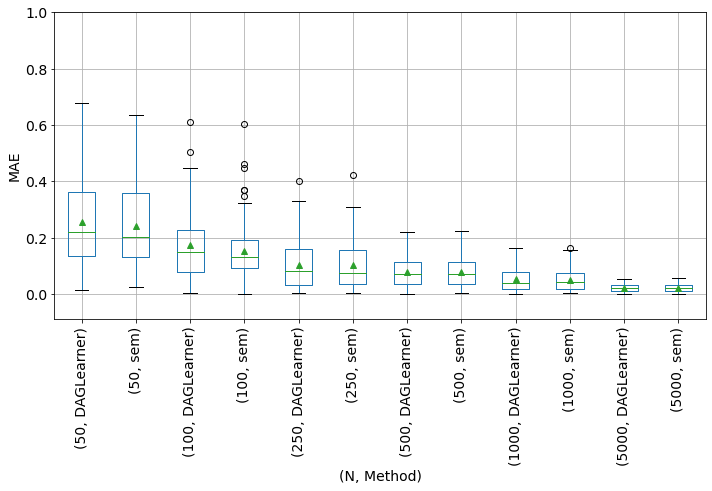

In [5]:
# import equivalent results from lavaan/R, truth, and daglearn results
results_truth = pd.read_csv(os.path.join(results_fn, 'simple_linear_confounder_empirical_ate.csv'))
results_df = pd.read_csv(os.path.join(results_fn, 'simple_linear_confounder_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_linear_confounder_sem_results.csv'))
results_df_R['mae'] = abs(results_df_R['coeff'] - results_truth['emp_ate'])
results_df['mae'] = abs(results_df['coeff'] - results_truth['emp_ate'])
# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

# Create boxplots
results.boxplot(column='mae', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_linear.png'), dpi=160)
plt.show()

# Linear but many confounders estimation

In [7]:
N = [50, 100, 250, 500, 1000, 5000]
seed = 42
np.random.seed(seed)
true_empirical_ATEs = {}
results = {}
for n in N:
    print("Simulating with sample size:", n)
    estATEs = []
    true_emps = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types, Y1, Y0  = gen_linear_many_confounders(n)
        true_emps.append((Y1-Y0).mean())
        df.to_csv(os.path.join(data_fn, 'linear_many_confounders_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG, k=k,  var_types=var_types, save_models=False)
        # fit the daglearner:
        daglearner.fit(data=df, verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']
        estATEs.append(estATE)
    estATEs = np.asarray(estATEs)    
    results[n] = estATEs
    true_emps = np.asarray(true_emps)
    true_empirical_ATEs[n] = true_emps

results_df = []
for N, coeffs in results.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'linear_many_confounders_daglearner_results.csv'), index=False) 

true_df = []
for N, ates in true_empirical_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'linear_many_confounders_empirical_ate.csv'), index=False) 

Simulating with sample size: 50
Simulating with sample size: 100
Simulating with sample size: 250
Simulating with sample size: 500
Simulating with sample size: 1000
Simulating with sample size: 5000


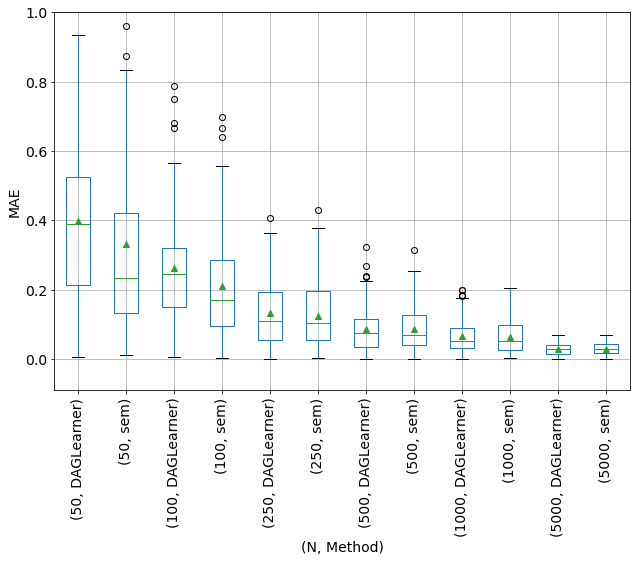

In [8]:
# import equivalent results from lavaan/R:
results_truth = pd.read_csv(os.path.join(results_fn, 'linear_many_confounders_empirical_ate.csv'))
results_df = pd.read_csv(os.path.join(results_fn, 'linear_many_confounders_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'linear_many_confounders_sem_results.csv'))

results_df_R['mae'] = abs(results_df_R['coeff'] - results_truth['emp_ate'])
results_df['mae'] = abs(results_df['coeff'] - results_truth['emp_ate'])
# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

# Create boxplots
results.boxplot(column='mae', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_linear_many_confs.png'), dpi=160)
plt.show()

# Nonlinear simple structure

In [9]:
N = [50, 100, 250, 500, 1000, 5000]
seed = 42
np.random.seed(seed)
true_empirical_ATEs = {}
results = {}
for n in N:
    print("Simulating with sample size:", n)
    estATEs = []
    true_emps = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types,Y1,Y0  = gen_simple_nonlinear_confounder(n)
        true_emps.append((Y1-Y0).mean())
        df.to_csv(os.path.join(data_fn, 'simple_nonlinear_confounder_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG,k=k, var_types=var_types, save_models=False)
        # fit the daglearner:
        daglearner.fit(data=df,  verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']
        estATEs.append(estATE)
    estATEs = np.asarray(estATEs)    
    results[n] = estATEs
    true_emps = np.asarray(true_emps)
    true_empirical_ATEs[n] = true_emps

results_df = []
for N, coeffs in results.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_daglearner_results.csv'), index=False) 

true_df = []
for N, ates in true_empirical_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_empirical_ate.csv'), index=False) 

Simulating with sample size: 50
Simulating with sample size: 100
Simulating with sample size: 250
Simulating with sample size: 500
Simulating with sample size: 1000
Simulating with sample size: 5000


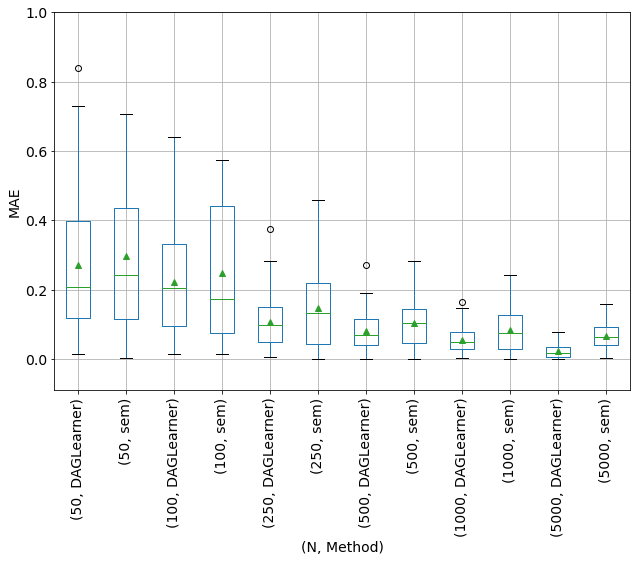

In [10]:
# import equivalent results from lavaan/R:
results_truth = pd.read_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_empirical_ate.csv'))
results_df = pd.read_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_nonlinear_confounder_sem_results.csv'))
results_df_R['mae'] = abs(results_df_R['coeff'] - results_truth['emp_ate'])
results_df['mae'] = abs(results_df['coeff'] - results_truth['emp_ate'])
# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

# Create boxplots
results.boxplot(column='mae', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_nonlinear.png'), dpi=160)
plt.show()

## Simple Mediation Model

In [13]:
N = [50, 100, 250, 500, 1000, 5000]
seed = 42
np.random.seed(seed)
true_total_ATEs = {}
true_direct_ATEs = {}
true_indirect_ATEs = {}
results_total = {}
results_direct = {}
results_indirect = {}
for n in N:
    print("Simulating with sample size:", n)
    estATEs_total = []
    estATEs_direct = []
    estATEs_indirect = []
    true_total =  1.14 # direct effect = 0.5, indirect = 0.8 * 0.8, total = 1.14
    true_direct = 0.5
    true_indirect = 0.64
    true_totals = []
    true_directs = []
    true_indirects = []
    for i in range(trials):
        # and a dictionary of variable types (continuous='cont', categorial='cat', or binary='bin'):
        df, DAG, var_types, _, _  = gen_simple_linear_mediation(n)
        true_totals.append(true_total)  # read from graph
        true_directs.append(true_direct)
        true_indirects.append(true_indirect)
        df.to_csv(os.path.join(data_fn, 'simple_mediation_N_{}_i_{}.csv'.format(n, i)), index=False)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG,k=k, var_types=var_types, save_models=False)
        # fit the daglearner:
        daglearner.fit(data=df,  verbose=False)

        ## FIRST TOTAL EFFECT
        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)
        int_val_nodes1 = {'X': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE_total = estATE_dataset['Y']
        estATEs_total.append(estATE_total)
        
        ## SECOND X -> M  (already computed as part of intervening on X)
        estATE_xm = estATE_dataset['M']
        
        ## THIRD M -> Y  
        int_val_nodes0 = {'M': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)
        int_val_nodes1 = {'M': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE_my = estATE_dataset['Y']
        
        # note that this assumes linearity! In practice we want to explore possible nonlinear interactions
        estATE_indirect = estATE_xm*estATE_my
        estATEs_indirect.append(estATE_indirect)
        estATE_direct = estATE_total - estATE_indirect
        estATEs_direct.append(estATE_direct)
        
    estATEs_total = np.asarray(estATEs_total)
    estATEs_direct = np.asarray(estATEs_direct)   
    estATEs_indirect = np.asarray(estATEs_indirect)   
    
    results_total[n] = estATEs_total
    results_direct[n] = estATEs_direct
    results_indirect[n] = estATEs_indirect
    
    true_totals = np.asarray(true_totals)
    true_directs = np.asarray(true_directs)
    true_indirects = np.asarray(true_indirects)
    true_total_ATEs[n] = true_totals
    true_direct_ATEs[n] = true_directs
    true_indirect_ATEs[n] = true_indirects
    
results_df = []
for N, coeffs in results_total.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_mediation_daglearner_total_results.csv'), index=False) 

results_df = []
for N, coeffs in results_indirect.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_mediation_daglearner_indirect_results.csv'), index=False) 

results_df = []
for N, coeffs in results_direct.items():
    for i, coeff in enumerate(coeffs):
        results_df.append({"N": N, "i": i, "coeff": coeff})

results_df = pd.DataFrame(results_df)
results_df.to_csv(os.path.join(results_fn, 'simple_mediation_daglearner_direct_results.csv'), index=False) 

true_df = []
for N, ates in true_total_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_mediation_empirical_total_ate.csv'), index=False)

true_df = []
for N, ates in true_direct_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_mediation_empirical_direct_ate.csv'), index=False) 

true_df = []
for N, ates in true_indirect_ATEs.items():
    for i, ate in enumerate(ates):
        true_df.append({"N": N, "i": i, "emp_ate": ate})

true_df = pd.DataFrame(true_df)
true_df.to_csv(os.path.join(results_fn, 'simple_mediation_empirical_indirect_ate.csv'), index=False) 

Simulating with sample size: 50


KeyboardInterrupt: 

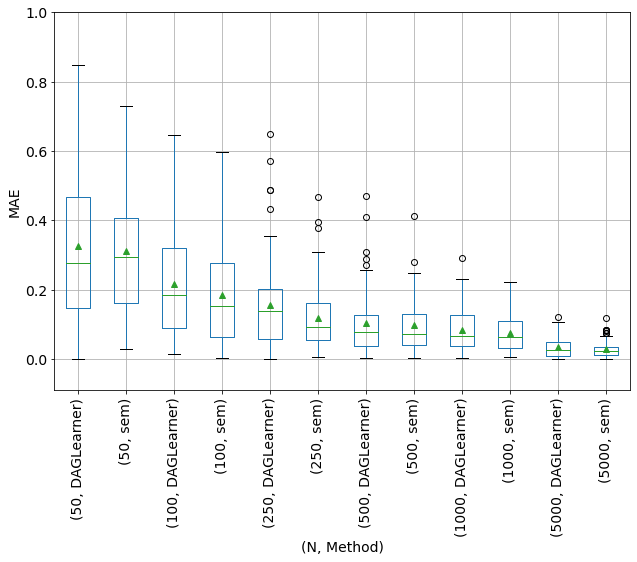

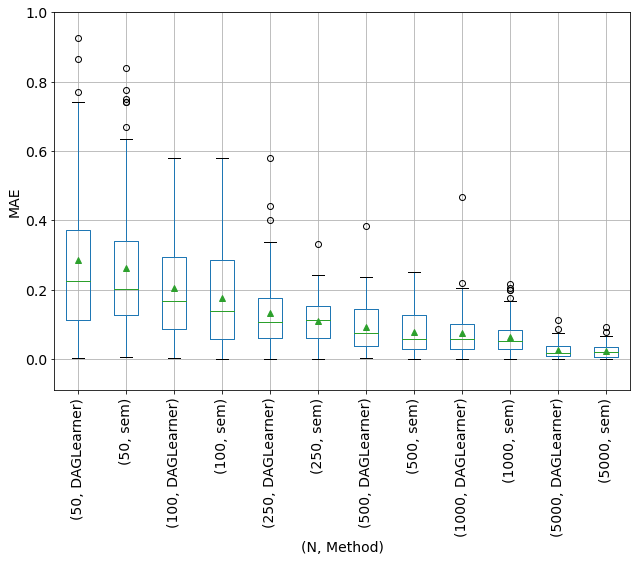

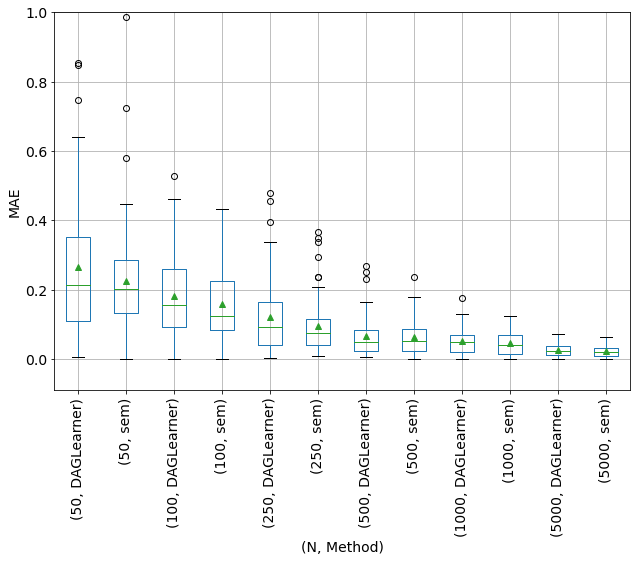

In [14]:
# import equivalent results from lavaan/R:
results_total_truth = pd.read_csv(os.path.join(results_fn, 'simple_mediation_empirical_total_ate.csv'))
results_direct_truth = pd.read_csv(os.path.join(results_fn, 'simple_mediation_empirical_direct_ate.csv'))
results_indirect_truth = pd.read_csv(os.path.join(results_fn, 'simple_mediation_empirical_indirect_ate.csv'))

results_df_total = pd.read_csv(os.path.join(results_fn, 'simple_mediation_daglearner_total_results.csv'))
results_df_direct = pd.read_csv(os.path.join(results_fn, 'simple_mediation_daglearner_direct_results.csv'))
results_df_indirect = pd.read_csv(os.path.join(results_fn, 'simple_mediation_daglearner_indirect_results.csv'))

results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_mediation_sem_results.csv'))


results_df_R['mae_total'] = abs(results_df_R['coeff_total'] - results_total_truth['emp_ate'])
results_df_total['mae_total'] = abs(results_df_total['coeff'] - results_total_truth['emp_ate'])

results_df_R['mae_direct'] = abs(results_df_R['coeff_direct'] - results_direct_truth['emp_ate'])
results_df_direct['mae_direct'] = abs(results_df_direct['coeff'] - results_direct_truth['emp_ate'])

results_df_R['mae_indirect'] = abs(results_df_R['coeff_indirect'] - results_indirect_truth['emp_ate'])
results_df_indirect['mae_indirect'] = abs(results_df_indirect['coeff'] - results_indirect_truth['emp_ate'])

# combine sem and daglearner results
results_df_R['method'] = 'sem'
results_df_total['method'] = 'DAGLearner'
results_total = pd.concat([results_df_total, results_df_R])

# combine sem and daglearner results
results_df_direct['method'] = 'DAGLearner'
results_direct = pd.concat([results_df_direct, results_df_R])

# combine sem and daglearner results
results_df_indirect['method'] = 'DAGLearner'
results_indirect = pd.concat([results_df_indirect, results_df_R])

# Create boxplots
results_total.boxplot(column='mae_total', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_mediation_total.png'), dpi=160)
plt.show()

# Create boxplots
results_direct.boxplot(column='mae_direct', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_mediation_direct.png'), dpi=160)
plt.show()


# Create boxplots
results_indirect.boxplot(column='mae_indirect', by=['N', 'method'], grid=False, showmeans=True, figsize=(10,7), fontsize = 14)

# Show the plot
plt.title("")
plt.suptitle("")
plt.xlabel("(N, Method)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.ylim(-0.09,1)
plt.savefig(os.path.join(plots_fn, 'MAE_simple_mediation_indirect.png'), dpi=160)
plt.show()

## Simply polynomial with varying non-linearity

In [204]:
N = 10000
ps = np.arange(0.0001, 0.05, 0.001)
repeats = 20
seed = 42
np.random.seed(seed)
lm_results = {}
results = {}
for p in ps:
    ests = []
    params = []
    for r in range(repeats):
        df, DAG, var_types = gen_simple_poly(N=N, p=p, degree=3)
        df.to_csv(os.path.join(data_fn, 'simple_poly_N_{}_p_{}.csv'.format(N, p)), index=False)

        # Fit a linear regression model using statsmodels
        X = sm.add_constant(df[['X1', 'X2']]) # adding a constant (intercept term) to the model
        model = sm.OLS(df['Y'], X)
        summary = model.fit()

        print("Simulating with nonlinearity:", p)
        # initialise the daglearner:
        daglearner = DAGLearner(dag=DAG,k=k, var_types=var_types, save_models=False)
        # fit the daglearn\er:
        daglearner.fit(data=df,  verbose=False)

        # estimate specific inteventions and update dataset with result:
        int_val_nodes0 = {'X2': 0}
        interventional_dataset0 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes0)

        int_val_nodes1 = {'X2': 1}
        interventional_dataset1 = daglearner.infer(data=df, intervention_nodes_vals=int_val_nodes1)
        # get average results of interventions
        estATE_dataset =  (interventional_dataset1 - interventional_dataset0).mean()
        estATE = estATE_dataset['Y']
        print(p, estATE)  
        params.append(summary.params['X2'])
        ests.append(estATE)
    params = np.asarray(params)
    ests = np.asarray(ests)
    lm_results[p] = params.mean()
    results[p] = ests.mean()
    
results_df = pd.DataFrame(list(results.items()), columns=['p', 'coeff'])
results_df.to_csv(os.path.join(results_fn, 'simple_poly_daglearner_results.csv'), index=False)
results_df_lm = pd.DataFrame(list(lm_results.items()), columns=['p', 'coeff'])
results_df_lm.to_csv(os.path.join(results_fn, 'simple_poly_lm_results.csv'), index=False)

Simulating with nonlinearity: 0.0001
0.0001 -0.004960141310970934
Simulating with nonlinearity: 0.0001
0.0001 -0.01066527278534305
Simulating with nonlinearity: 0.0001
0.0001 -0.001895463099778766
Simulating with nonlinearity: 0.0001
0.0001 -0.003106018150780783
Simulating with nonlinearity: 0.0001
0.0001 0.0008941780634481722
Simulating with nonlinearity: 0.0001
0.0001 -0.002595742339078902
Simulating with nonlinearity: 0.0001
0.0001 -0.013149238431664273
Simulating with nonlinearity: 0.0001
0.0001 -0.016713537059626953
Simulating with nonlinearity: 0.0001
0.0001 0.009950708001943616
Simulating with nonlinearity: 0.0001
0.0001 -0.03593053992463355
Simulating with nonlinearity: 0.0001
0.0001 -0.005136421213055853
Simulating with nonlinearity: 0.0001
0.0001 -0.0055351202676488555
Simulating with nonlinearity: 0.0001
0.0001 0.0010391625866010357
Simulating with nonlinearity: 0.0001
0.0001 0.01947714738234518
Simulating with nonlinearity: 0.0001
0.0001 0.00577284906965569
Simulating with 

0.0061 0.03882621813558181
Simulating with nonlinearity: 0.0061
0.0061 0.09602666815639853
Simulating with nonlinearity: 0.0061
0.0061 0.03230680955257321
Simulating with nonlinearity: 0.0061
0.0061 0.03516443580048941
Simulating with nonlinearity: 0.0061
0.0061 0.0016506989691685327
Simulating with nonlinearity: 0.0061
0.0061 0.013763753304683326
Simulating with nonlinearity: 0.0061
0.0061 -0.0289311155596865
Simulating with nonlinearity: 0.0061
0.0061 0.020453387134139803
Simulating with nonlinearity: 0.0061
0.0061 0.03556040208633723
Simulating with nonlinearity: 0.0061
0.0061 0.02937097940892902
Simulating with nonlinearity: 0.0061
0.0061 0.011750618181385735
Simulating with nonlinearity: 0.0061
0.0061 0.033519746043798974
Simulating with nonlinearity: 0.0061
0.0061 -0.004692598819307606
Simulating with nonlinearity: 0.0061
0.0061 -0.012826915314145683
Simulating with nonlinearity: 0.0061
0.0061 -0.027835116998566292
Simulating with nonlinearity: 0.0071
0.0071 0.024271647123955877


0.0121 0.0030578568462345966
Simulating with nonlinearity: 0.0121
0.0121 0.00835387489810303
Simulating with nonlinearity: 0.0121
0.0121 0.029989663018108393
Simulating with nonlinearity: 0.0121
0.0121 -0.0029408277222920014
Simulating with nonlinearity: 0.0121
0.0121 -0.01978447774965677
Simulating with nonlinearity: 0.0121
0.0121 0.013800982463081977
Simulating with nonlinearity: 0.0121
0.0121 0.027798266126174382
Simulating with nonlinearity: 0.0121
0.0121 -0.03239685127704302
Simulating with nonlinearity: 0.0121
0.0121 -0.013549080779777912
Simulating with nonlinearity: 0.0121
0.0121 0.02077430310872547
Simulating with nonlinearity: 0.0121
0.0121 -0.005560754379175535
Simulating with nonlinearity: 0.0121
0.0121 0.010133203222637558
Simulating with nonlinearity: 0.0121
0.0121 -0.04745899276230018
Simulating with nonlinearity: 0.0121
0.0121 -0.041657931928735306
Simulating with nonlinearity: 0.0121
0.0121 -0.024946895858766503
Simulating with nonlinearity: 0.0121
0.0121 -0.0262034898

0.0181 -0.006954945372055107
Simulating with nonlinearity: 0.0181
0.0181 0.03055491129391567
Simulating with nonlinearity: 0.0181
0.0181 -0.00019235108113408407
Simulating with nonlinearity: 0.0181
0.0181 0.050271095954829835
Simulating with nonlinearity: 0.0181
0.0181 -0.03981168572607294
Simulating with nonlinearity: 0.0181
0.0181 0.011495426809290846
Simulating with nonlinearity: 0.0181
0.0181 0.012572559762736102
Simulating with nonlinearity: 0.0181
0.0181 0.04375888714645954
Simulating with nonlinearity: 0.0181
0.0181 -0.03268828947898107
Simulating with nonlinearity: 0.0181
0.0181 -0.0629512722718035
Simulating with nonlinearity: 0.0181
0.0181 0.03481868551031916
Simulating with nonlinearity: 0.0181
0.0181 -0.058930505796706806
Simulating with nonlinearity: 0.0181
0.0181 0.020452074768414787
Simulating with nonlinearity: 0.0181
0.0181 -0.044259385095961654
Simulating with nonlinearity: 0.0181
0.0181 0.008105077637583745
Simulating with nonlinearity: 0.0181
0.0181 -0.0243146135646

0.0231 0.031081626087446072
Simulating with nonlinearity: 0.0231
0.0231 0.011747510573283887
Simulating with nonlinearity: 0.0241
0.0241 0.045035262050762026
Simulating with nonlinearity: 0.0241
0.0241 0.009608163443001746
Simulating with nonlinearity: 0.0241
0.0241 0.023308090406302065
Simulating with nonlinearity: 0.0241
0.0241 0.04662168543197429
Simulating with nonlinearity: 0.0241
0.0241 -0.009769693192009791
Simulating with nonlinearity: 0.0241
0.0241 0.013762907957668406
Simulating with nonlinearity: 0.0241
0.0241 -0.01830425312512103
Simulating with nonlinearity: 0.0241
0.0241 0.005476995287916286
Simulating with nonlinearity: 0.0241
0.0241 0.01969928762931322
Simulating with nonlinearity: 0.0241
0.0241 -0.015914721649975393
Simulating with nonlinearity: 0.0241
0.0241 0.04526599435982939
Simulating with nonlinearity: 0.0241
0.0241 0.04023623709383959
Simulating with nonlinearity: 0.0241
0.0241 0.02401316696416561
Simulating with nonlinearity: 0.0241
0.0241 0.0009475297629905924

0.0301 -0.019579480535114456
Simulating with nonlinearity: 0.0301
0.0301 0.023438587802072305
Simulating with nonlinearity: 0.0301
0.0301 0.012374326110064926
Simulating with nonlinearity: 0.0301
0.0301 0.015225452246105189
Simulating with nonlinearity: 0.0301
0.0301 0.03350350998697042
Simulating with nonlinearity: 0.0301
0.0301 0.026981565593530984
Simulating with nonlinearity: 0.0301
0.0301 0.0423140626645152
Simulating with nonlinearity: 0.0301
0.0301 0.00770636260621427
Simulating with nonlinearity: 0.0301
0.0301 -0.016487614183813348
Simulating with nonlinearity: 0.0301
0.0301 -0.04172516758555428
Simulating with nonlinearity: 0.0301
0.0301 0.013212444453808286
Simulating with nonlinearity: 0.0301
0.0301 -0.0006733799600547714
Simulating with nonlinearity: 0.0301
0.0301 0.0300460103646609
Simulating with nonlinearity: 0.0301
0.0301 -0.025719926108683455
Simulating with nonlinearity: 0.0301
0.0301 -0.04848270474827549
Simulating with nonlinearity: 0.0311
0.0311 0.00991418838760981

0.035100000000000006 0.022043311607914534
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 -0.012943282917919149
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 0.035795621415470255
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 0.0037736860904091004
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 0.028124850088556138
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 0.031274540658831215
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 0.011918832509967952
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 0.06247706145376272
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 -0.07320570398934563
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 -0.007500427696254303
Simulating with nonlinearity: 0.035100000000000006
0.035100000000000006 -0.006537623509978394
Simulating with nonlinear

0.040100000000000004 0.030186484700532902
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 0.004716263922572665
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 -0.00036462390560075086
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 0.028727839508742862
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 0.04274178745541012
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 0.08029124313429584
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 -0.0048506072700311145
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 0.018299591084730314
Simulating with nonlinearity: 0.040100000000000004
0.040100000000000004 0.011439916906705715
Simulating with nonlinearity: 0.041100000000000005
0.041100000000000005 0.03950133926062545
Simulating with nonlinearity: 0.041100000000000005
0.041100000000000005 0.020181655411582518
Simulating with nonlineari

0.0451 -0.07687345618561664
Simulating with nonlinearity: 0.0451
0.0451 -0.02439615564722908
Simulating with nonlinearity: 0.0451
0.0451 -0.004907787115709341
Simulating with nonlinearity: 0.0451
0.0451 0.006800873751371064
Simulating with nonlinearity: 0.0451
0.0451 0.0075156616048284745
Simulating with nonlinearity: 0.0451
0.0451 0.0426841799196097
Simulating with nonlinearity: 0.0451
0.0451 -0.011373695757203683
Simulating with nonlinearity: 0.0451
0.0451 0.0010272417747525966
Simulating with nonlinearity: 0.0451
0.0451 0.010768475883660549
Simulating with nonlinearity: 0.0451
0.0451 0.06492561632427628
Simulating with nonlinearity: 0.0451
0.0451 0.07121089807345238
Simulating with nonlinearity: 0.0451
0.0451 -0.012237992422234799
Simulating with nonlinearity: 0.0461
0.0461 0.011933584044650935
Simulating with nonlinearity: 0.0461
0.0461 0.009837186923640835
Simulating with nonlinearity: 0.0461
0.0461 0.05244865633661143
Simulating with nonlinearity: 0.0461
0.0461 0.0169822894016966

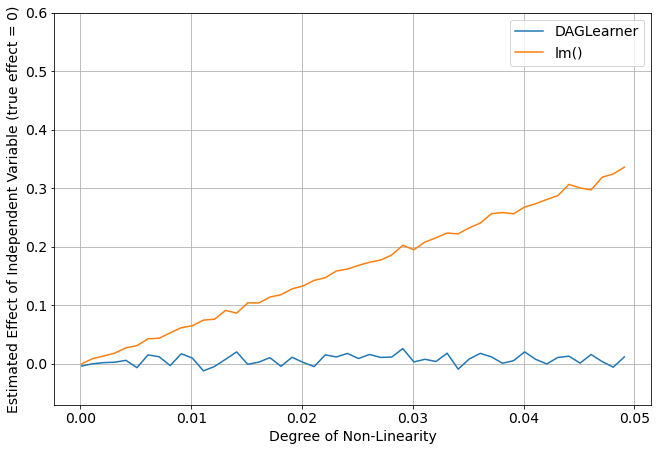

In [205]:
results_df = pd.read_csv(os.path.join(results_fn, 'simple_poly_daglearner_results.csv'))
results_df_R = pd.read_csv(os.path.join(results_fn, 'simple_poly_lm_results.csv'))

# combine sem and daglearner results
results_df_R['method'] = 'lm'
results_df['method'] = 'DAGLearner'
results = pd.concat([results_df, results_df_R])

plt.figure(figsize=(9,6))
plt.plot(results[results.method=='DAGLearner'].p, results[results.method=='DAGLearner'].coeff, label='DAGLearner')
plt.plot(results[results.method=='lm'].p, results[results.method=='lm'].coeff, label='lm()')
plt.grid()
plt.tight_layout()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Estimated Effect of Independent Variable (true effect = 0)',fontsize=14)
plt.xlabel('Degree of Non-Linearity',fontsize=14)
plt.ylim(-0.07, 0.6)
plt.legend(fontsize=14)
plt.savefig(os.path.join(plots_fn, 'simple_poly_comparison.png'), dpi=160)
plt.show()